In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_relative_footsteps_acc
%store -r Y_relative_footsteps_acc
print(X_relative_footsteps_acc.shape)
print(Y_relative_footsteps_acc.shape)

(21881, 28)
(21881, 8)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
X_relative_footsteps_acc[0, :]

array([ 0.        ,  0.        ,  0.        , -0.01667854,  0.02806931,
        0.04898649, -0.00293043,  0.04369139, -0.00966195,  0.22882891,
        0.16832004, -0.40987395,  0.23396882, -0.16832977, -0.40997042,
       -0.24291083,  0.16426133, -0.41338172, -0.24842681, -0.16367363,
       -0.41372354,  0.        ,  1.        ,  1.        ,  0.        ,
        0.1       ,  0.        ,  0.        ])

In [8]:
# Entries where FL is in support
idxs = np.where(X_relative_footsteps_acc[:, 21] == 0)[0]
X_relative_footsteps_acc_FL_support = X_relative_footsteps_acc[idxs]
Y_relative_footsteps_acc_FL_support = Y_relative_footsteps_acc[idxs]

## Predict FL foot -> x

In [9]:
X_relative_footsteps_acc_FL_support.shape

(11025, 28)

In [10]:
X_relative_footsteps_acc_FL_support[0, :]

array([ 0.        ,  0.        ,  0.        , -0.01667854,  0.02806931,
        0.04898649, -0.00293043,  0.04369139, -0.00966195,  0.22882891,
        0.16832004, -0.40987395,  0.23396882, -0.16832977, -0.40997042,
       -0.24291083,  0.16426133, -0.41338172, -0.24842681, -0.16367363,
       -0.41372354,  0.        ,  1.        ,  1.        ,  0.        ,
        0.1       ,  0.        ,  0.        ])

In [11]:
Y_relative_footsteps_acc_FL_support[0, :]

array([ 0.23372304,  0.17114156,  0.23612243, -0.16703353, -0.24142041,
        0.16586816, -0.24356714, -0.16141067])

### Linear Regression

In [34]:
# Input
X = np.hstack((X_relative_footsteps_acc_FL_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_FL_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_FL_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_FL_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_FL_support[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8274078258368927
RMSE:  0.01087896298927022
The lowest error is:  7.026621307026915e-07
The highest error is:  0.062454743776991506
The avg. error is:  0.007283331316161567


In [35]:
model_fl_relative_support_x.coef_

array([[-0.08657218,  0.05191882,  0.09989837, -0.05641254, -0.008118  ,
         0.00185887,  1.09047608, -0.04438799, -0.09568431, -0.14009462,
         0.11344721, -0.15655122, -0.15898238, -0.62952967]])

In [36]:
model_fl_relative_support_x.intercept_

array([-0.09969976])

Text(0, 0.5, 'Predictions')

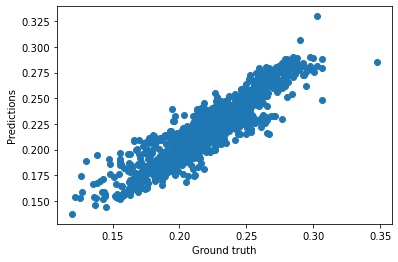

In [37]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [38]:
#%store model_fl_relative_support_x

In [39]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [40]:
# Save model
#joblib.dump(model_fl_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_x.sav")

### Predict FL foot -> y

In [66]:
# Input
X = np.hstack((X_relative_footsteps_acc_FL_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_FL_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_FL_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_FL_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_FL_support[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8830224926904007
RMSE:  0.010990377703342427
The lowest error is:  5.853556710566643e-06
The highest error is:  0.05861811070992343
The avg. error is:  0.007735150364707297


In [67]:
model_fl_relative_support_y.coef_

array([[ 0.04120403, -0.11645396, -0.24073119, -0.01618937, -0.04252555,
        -0.09002542,  0.17477286,  1.0719235 , -0.15638242, -0.19948911,
         0.11491228,  0.08260257, -0.4575788 ,  0.03922617]])

In [68]:
model_fl_relative_support_y.intercept_

array([-0.13619293])

Text(0, 0.5, 'Predictions')

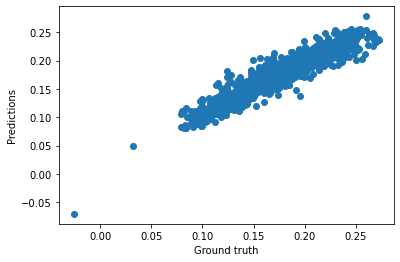

In [69]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [213]:
#%store model_fl_relative_support_y

In [214]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [215]:
# Save model
#joblib.dump(model_fl_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_y.sav")